In [1]:
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from torchvision import transforms
import cv2
from albumentations.augmentations.transforms import Lambda, RandomBrightnessContrast
from albumentations.augmentations.geometric.transforms import ShiftScaleRotate, HorizontalFlip
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.crops.transforms import RandomResizedCrop
from albumentations import Compose
from torch import nn
import collections
import myKit

In [2]:
import matplotlib.pyplot as plt
from d2l import torch as d2l
import csv

In [25]:
loss = nn.L1Loss(reduction='none')
a = torch.zeros((230,1))
b = torch.ones((10,1))
d = torch.zeros((10, 1))
for i in range(b.shape[0]):
    if a[i]:
        b[i] += i
    
# out = torch.cat([a, b], dim=0)
out = loss(d, b)
# out[4]
c = torch.rand((10, 1))
for i in range(b.shape[0]):
    a[int(b[i])] += 1

b

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [4]:
for i in range(10):
    print(i)

0
1
2
3
4
5
6
7
8
9


In [5]:
list1 = torch.ones(10, 1)
list2 = torch.zeros(10, 1)
print('预测值 实际值')
# for data1, data2 in zip(list1, list2):
#     print(f'{data1.item()},   {data2.item()}')
idx = slice(4, len(list1)-1)
idx

预测值 实际值


slice(4, 9, None)

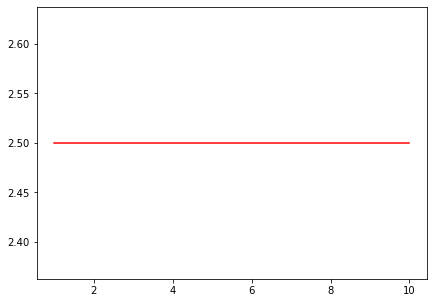

In [6]:
output = torch.ones(10, 1, requires_grad=True)*2.5
target = torch.ones(10, 1)
LOSSresult = nn.L1Loss(reduction='sum') #设置损失函数的参数/实例化
# type(LOSSresult(output, target).item())
# for i in range(8):
#     print(i)
x = list(range(1, len(output)+1))
y = output.tolist()
x1 = list(range(1, len(target)+1))
y1 = target.tolist()
fig = plt.figure(figsize=(7, 5))
ax1 = fig.add_subplot(1, 1, 1)

plt.plot(x, y, 'r-')
# plt.legend()
# plt.xlabel(u'iters')
# plt.ylabel(u'loss')
# plt.title('Compare loss for different models in training.')
# plt.show()

In [7]:
a = torch.rand((3, 512, 512))
b = torch.rand((3, 512, 512))
c = torch.cat([a, b], dim=0)
d = torch.reshape(a, (1, 3, 512 ,512))
e = torch.randint(1, 10, (10, 1))
e_label = torch.zeros((10, 230))
for i in range(e.shape[0]):
    e_label[i][e[i][0]] = 1
e_label.shape

torch.Size([10, 230])

In [8]:
def read_csv_labels_noMale(fname):
    """读取标签，返回字典格式`"""
    with open(fname, 'r') as f:
        # Skip the file header line (column name) 跳过文件头
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    # return dict(((id, boneage) for id, boneage, male in tokens))
    return dict((id, boneage) for id, boneage, male in tokens)

original_labels = read_csv_labels_noMale('../data/archive/boneage-training-dataset.csv')
train_labels = read_csv_labels_noMale('../data/archive/train-dataset.csv')
valid_labels = read_csv_labels_noMale('../data/archive/valid-dataset.csv')
original_df = pd.read_csv('../data/archive/boneage-training-dataset.csv')
train_df = pd.read_csv('../data/archive/train-dataset.csv')
valid_df = pd.read_csv('../data/archive/valid-dataset.csv')

第一步：先从valid_csv中删除多于2的记录
算法步骤：从头遍历csv，每个年龄最多取两次，生成新的csv文件

In [9]:
count = collections.Counter(valid_labels.values())
need_aug_age = []
for key in count.keys():
    if count[key] < 2:
        need_aug_age.append(key)

for age in need_aug_age:
    for key in original_labels.keys():
        if age == str(original_labels[key]):
            if key not in train_labels.keys() and key not in valid_labels.keys():
                print(key)
                break

1545
3225
1851
2030
3215
3061
1685
1590
5866
4239
3260
2845
3080
1605
3407
3249
1899
3155
3680
1512
5921
5830
3484
2657
3875
2148
4078
4281
1865
2712
1840
3354
2168
2507
2871
4753
3547
3465
1781
1775
2970
2853
2213
1873
2505
4277
2934
4788
3568
4193
2799
3700
1799
3898
8633
3602
2070
3876
3459
3928
3120
3173
1936
2176
2838
7191
2160
1964
2271
2626
2834
5409
2108
3448
3535
3387
3840
3998
2858
4018
3121
7886
7939
3187
3331
3174
5366
3421
10055
3436
3503
3590
3900
3935
8717
12023
6912
7038
13038
14486


In [10]:
def delete_from_csv(DF, data_num):
    """从验证的csv中删除多于data_num的记录"""
    valid_list = [['id', 'boneage', 'male']]
    label_count = {}
    for idx, row in DF.iterrows():
        label = str(row['boneage'])
        if label not in label_count or label_count[label] < data_num:
            valid_list.append([row['id'], row['boneage'], row['male']])
            label_count[label] = label_count.get(label, 0) + 1
    with open('../data/archive/delete_from_csv.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in valid_list:
            writer.writerow(row)

def aug_from_csv(valid_labels, train_df, original_labels):
    """将裁剪过的csv，增广到所需要的csv，默认增广到2"""
    valid_list = []
    count = collections.Counter(valid_labels.values())
    need_aug_age = []
    for key in count.keys():
        if count[key] < 2:
            need_aug_age.append(key)
            # print(key)
    need_id = {}
    for age in need_aug_age:
        for key1 in original_labels.keys():
            if age == str(original_labels[key1]):
                if key1 not in train_labels.keys() and key1 not in valid_labels.keys():
                    need_id[key] = 0
                    break
    print(need_id.keys())
    # for idx, row in train_df.iterrows():
    #     if row['id'] in need_id.keys():
    #         valid_list.append([row['id'], row['boneage'], row['male']])
    # with open('../data/archive/delete_from_csv.csv', 'a+', newline='') as csvfile:
    #     writer = csv.writer(csvfile)
    #     for row in valid_list:
    #         writer.writerow(row)

# delete_from_csv(valid_df, 2)



In [11]:
def create_dataset_from_csv(DF):
    """从验证的csv中删除多于data_num的记录"""
    label_count = {}
    for idx, row in DF.iterrows():
        label = str(row['boneage'])
        filename = os.path.join('../data/archive/boneage-training-dataset', f"{row['id']}.png")
        myKit.copyfile(filename, os.path.join('../data/archive', 'valid-dataset'))
create_dataset_from_csv(valid_df)

In [12]:
new_valid_lables = read_csv_labels_noMale('../data/archive/delete_from_csv.csv')
# aug_from_csv(new_valid_lables, train_df, original_labels)

In [13]:
# new_valid = read_csv_labels_noMale('../data/archive/delete_from_csv.csv')
# collections.Counter(new_valid.values())